<a href="https://colab.research.google.com/github/RafalKaufman/Birth-death-model-python/blob/main/Birth_death_model_Rafa%C5%82_Kaufman(in_Polish).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proces narodzin - śmierci

##Wstęp

Model ten opisuje, na przykład, wzrost liczebności dobrze wymieszanej populacji komórek, które rozmnażają się oraz umierają z szybkością odpowiednio $\theta_1$ oraz $\theta_2$.

Prosty, deterministyczny model dla wzrostu populacji wygląda następująco:
\begin{cases} \frac{dx(t)}{dt}=\theta_1x-\theta_2x \\x(0)=x_0, \end{cases}
gdzie $x(t)$ to populacja w chwili $t$, a $\theta_1$ oraz $\theta_2$ to odpowiednio współczynniki narodzin i śmierci.

Rozwiązaniem powyższego układu jest funkcja:
$x(t)=x_0\exp((\theta_1-\theta_2)t).$

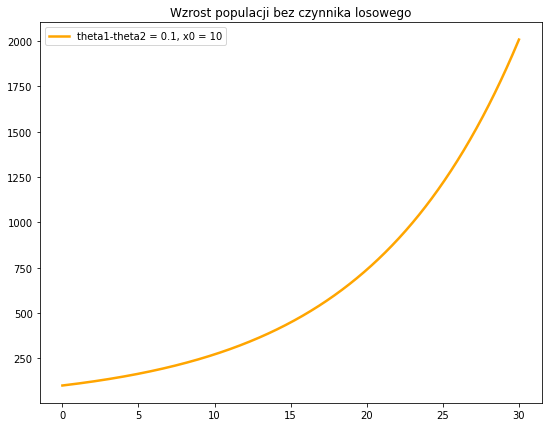

In [13]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
x_0 = 100
theta_1 = 1.5
theta_2 = 1.4
x = np.linspace(0, 30, 1001)
y = x_0*np.exp((theta_1-theta_2)*x)

plt.rcParams["figure.figsize"] = (9,7)
plt.plot(x, y, label="theta1-theta2 = 0.1, x0 = 10", color="orange", linewidth=2.5)
plt.title("Wzrost populacji bez czynnika losowego")
plt.legend()
plt.show()

W realnym świecie natomiast populacja zmienia się w sposób niejednostajny ze względu na pewną losowość wśród narodzin oraz śmierci.

Stochastyczne równanie różniczkowe opisujące zjawisko wzrostu populacji z uwzględnieniem losowych zmian dla małego interwału czasowego $Δt$ wygląda jak poniżej:
$dX(t)=(\theta_1-\theta_2)xdt+\sqrt{(\theta_1+\theta_2)x} dW(t),$
gdzie $W(t)$ jest procesem Wienera.

##Generowanie trajektorii

In [14]:
#Symulacja procesu Wienera

T = 30
N = 100

def Wiener(T, N):
  t = np.zeros(N+1)
  w = np.zeros(N+1)
  h = T/N
  for i in range(1,N+1):
    t[i] = t[i-1]+h
    w[i] = w[i-1]+np.sqrt(h)*np.random.normal()
  return t, w

###Schemat Eulera-Mayoramy

In [15]:
#Schemat Eulera-Mayoramy rozwiązania numerycznego

def a(x):
  return (theta_1-theta_2)*x

def b(x):
  if x>0:
    return np.sqrt((theta_1+theta_2)*x)
  return 0

def Euler_Mayorama(k, X_0, T, N, w):
  p = int((N/k)+1)
  w = w[::k]
  x = np.zeros(p)
  y = np.zeros(p)
  x[0] = 0
  y[0] = x_0
  h = T/(p-1)
  for i in range(1, p):
    deltaW = w[i]-w[i-1]
    x[i] = x[i-1]+h
    y[i] = y[i-1]+a(y[i-1])*h+b(y[i-1])*deltaW
  return x, y

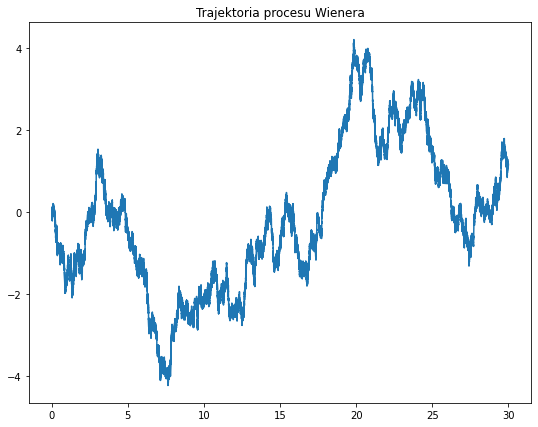

In [16]:
#Generowanie procesu Wienera

t, w = Wiener(T, N**3)
plt.plot(t, w)
plt.title("Trajektoria procesu Wienera")
plt.show()

In [17]:
#Rozwiązanie dokładne (używamy schematu numerycznego na gęstej siatce z h=0.00003)

x_dokl, y_dokl = Euler_Mayorama(1, x_0, T, N**3, w)

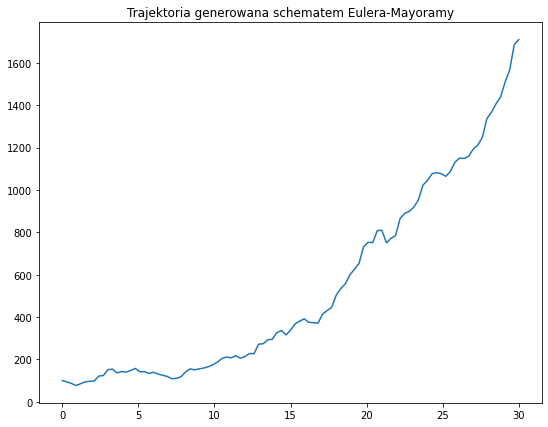

In [18]:
#Generowanie trajektorii modelu narodzin-śmierci schematem Eulera-Mayoramy

k = 10**4

x_przyb_E, y_przyb_E = Euler_Mayorama(k, x_0, T, N**3, w)
plt.plot(x_przyb_E, y_przyb_E)
plt.title("Trajektoria generowana schematem Eulera-Mayoramy")
plt.show()

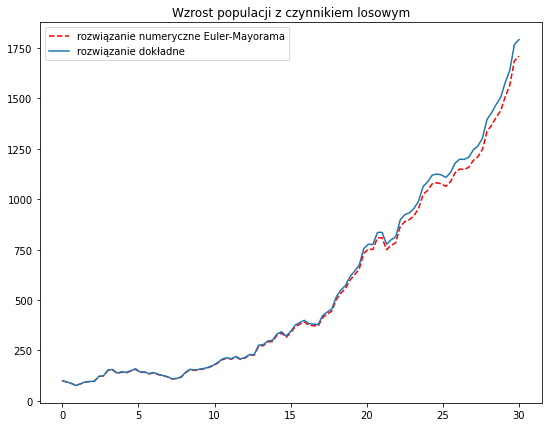

In [19]:
#Porównanie rozwiązania numerycznego schematem Eulera-Mayoramy z rozwiązaniem dokładnym

plt.rcParams["figure.figsize"] = (9,7)
plt.plot(x_przyb_E, y_przyb_E, "r--", color="red", label="rozwiązanie numeryczne Euler-Mayorama")
plt.plot(x_dokl[::10**4], y_dokl[::10**4], label="rozwiązanie dokładne")
plt.title("Wzrost populacji z czynnikiem losowym")  
plt.legend()
plt.show()

###Schemat Milsteina

In [20]:
#Schemat Milsteina rozwiązania numerycznego

def a_Milstein(x):
  return (theta_1-theta_2)*x

def b_Milstein(x):
  if x>=0:
    return np.sqrt((theta_1+theta_2)*x)
  return 0

def b_Milstein_prim(x):
  if x>0:
    return (1/2)*np.sqrt((theta_1+theta_2)/x)
  return 0

def Milstein(k, x_0, T, N, w):
  p = int((N/k)+1)
  w = w[::k]
  x = np.zeros(p)
  y = np.zeros(p)
  x[0] = 0
  y[0] = x_0
  h = T/(p-1)
  for i in range(1, p):
    deltaW = w[i]-w[i-1]
    x[i] = x[i-1]+h
    y[i] = y[i-1]+a_Milstein(y[i-1])*h+b_Milstein(y[i-1])*deltaW+0.5*(b_Milstein(y[i-1])*b_Milstein_prim(y[i-1])*(deltaW*deltaW-h))
  return x, y

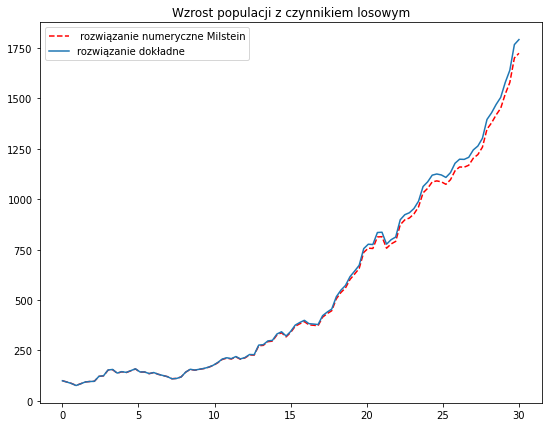

In [21]:
#Porównanie rozwiązania numerycznego schematem Milsteina z rozwiązaniem dokładnym

x_przyb_M, y_przyb_M = Milstein(k, x_0, T, N**3, w)
plt.plot(x_przyb_M, y_przyb_M, "r--", label=" rozwiązanie numeryczne Milstein", color="red")
plt.plot(x_dokl[::k], y_dokl[::k], label="rozwiązanie dokładne")
plt.title("Wzrost populacji z czynnikiem losowym")  
plt.legend()
plt.show()

###Schemat Wagnera-Platena

In [22]:
def a_W_P(t, x):
  return (theta_1-theta_2)*x

def b_W_P(t, x):
  if x>=0:
    return np.sqrt((theta_1+theta_2)*x)
  return 0

def a_prim_W_P(t, x):
  return theta_1-theta_2

def a_bis_W_P(t, x):
  return 0

def b_prim_W_P(t, x):
  if x>0:
    return np.sqrt((theta_1+theta_2)/x)*0.5
  return 0

def b_bis_W_P(t, x):
  if x>0:
    return -np.sqrt(theta_1+theta_2)*0.25*(x**(-3/2))
  return 0

def alfa_0_a(t, x):
  return (a_W_P(t, x)*a_prim_W_P(t, x))+0.5*((b_W_P(t, x)**2)*a_bis_W_P(t, x))

def alfa_0_b(t, x):
  return (a_W_P(t, x)*b_prim_W_P(t, x))+0.5*((b_W_P(t, x)**2)*b_bis_W_P(t, x))

def alfa_1_a(t, x):
  return b_W_P(t, x)*a_prim_W_P(t, x)

def alfa_1_b(t, x):
  return b_W_P(t, x)*b_prim_W_P(t, x) 

def I_0_0(h):
  return 0.5*h**2

def I_1_0(ksi1, ksi2, h):
  return 0.5*(ksi1+(1/np.sqrt(3))*ksi2)*h**(3/2)

def I_0_1(deltaWi, ksi1, ksi2, h):
  return (deltaWi)*h-I_1_0(ksi1, ksi2, h)

def I_1_1(deltaWi, h):
  return 0.5*((deltaWi**2)-h)

In [23]:
def Wagner_Platen(k, X_0, T, N, w):
  p = int((N/k)+1)
  w = w[::k]
  x = np.zeros(p)
  y = np.zeros(p)
  y[0] = x_0
  h = T/(p-1)
  for i in range(1, p):
    deltaW = w[i]-w[i-1]
    ksi_1 = deltaW/np.sqrt(h)
    ksi_2 = np.sqrt(h)*np.random.normal()
    x[i] = x[i-1]+h
    y[i] = y[i-1]+a_W_P(x[i-1],y[i-1])*h+b_W_P(x[i-1],y[i-1])*deltaW+alfa_0_a(x[i-1], y[i-1])*I_0_0(h)+alfa_1_a(x[i-1], y[i-1])*I_1_0(ksi_1, ksi_2, h)+alfa_0_b(x[i-1], y[i-1])*I_0_1(deltaW, ksi_1, ksi_2, h)+alfa_1_b(x[i-1], y[i-1])*I_1_1(deltaW, h)
  return x, y

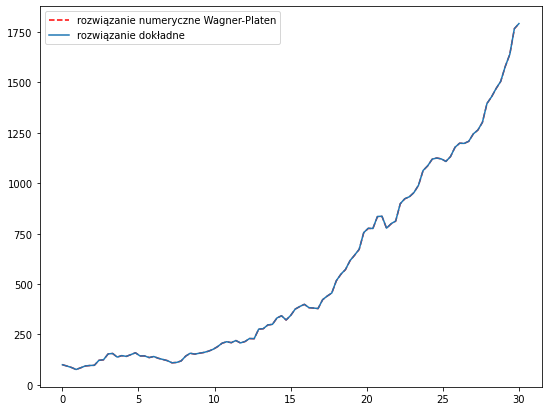

In [24]:
x_przyb_W, y_przyb_W = Wagner_Platen(k, x_0, T, N**3, w)
plt.plot(x_przyb_W, y_przyb_W, "r--", color="red", label="rozwiązanie numeryczne Wagner-Platen")
plt.plot(x_dokl[::k], y_dokl[::k], label="rozwiązanie dokładne")
plt.legend()
plt.show()

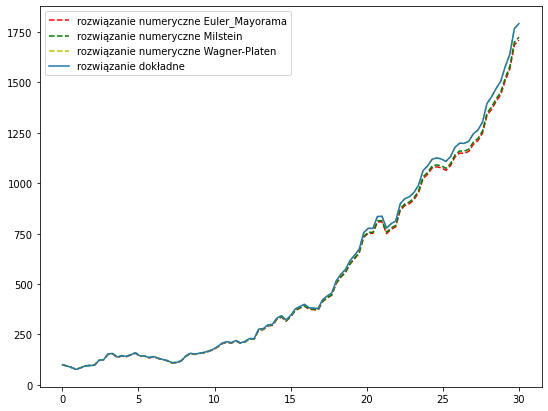

In [25]:
plt.plot(x_przyb_E, y_przyb_E, "r--", label="rozwiązanie numeryczne Euler_Mayorama")
plt.plot(x_przyb_M, y_przyb_M, "g--", label="rozwiązanie numeryczne Milstein")
plt.plot(x_przyb_W, y_przyb_W, "y--", label="rozwiązanie numeryczne Wagner-Platen")
plt.plot(x_dokl[::k], y_dokl[::k], label="rozwiązanie dokładne")
plt.legend()
plt.show()

##Estymacja momentów

Wartość oczekiwana procesu narodzin-śmierci jest dana wzorem:
$E(X(t))=x_0exp((\theta_1-\theta_0)t)$.
Z kolei odchylenie standardowe wygląda następująco:
$σ(X(t))=\sqrt{x_0(\theta_1+\theta_2)\frac{exp(2(\theta_1-\theta_2)t)-exp((\theta_1-\theta_2)t)}{\theta_1-\theta_2}}$
Wyestymujmy powyższe momenty dla tego procesu używając tradycyjnie, metody Monte Carlo.

In [26]:
#Estymacja wartości oczekiwanej na końcu przedziału

M = 100
l = 5

def Euler_Mayorama_1_1(k, X_0, T, N, w):
  p = int((N/k)+1)
  w = w[::k]
  x = np.zeros(p)
  y = np.zeros(p)
  y[0] = x_0
  h = T/(p-1)
  for i in range(1, p):
    deltaW = w[i]-w[i-1]
    y[i] = y[i-1]+a(y[i-1])*h+b(y[i-1])*deltaW
  return y[-1]

def E_X_Euler_Mayorama(k, M, x_0, T, N):
  suma = 0
  for i in range(M):
    t, w = Wiener(T, N)
    y = Euler_Mayorama_1_1(k, x_0, T, N, w)
    suma += y
  return suma/M

def mean_err_E_X(k, l, M, x_0, T, N, theta_1, theta_2):
  suma = 0
  x_2 = x_0*np.exp((theta_1-theta_2)*T)
  for i in range(l):
    x_1 = E_X_Euler_Mayorama(k, M, x_0, T, N)
    suma += np.abs(x_2-x_1)
  return (suma/l)/x_2

print(f'Pojedyncza estymacja wartości oczekiwanej: {E_X_Euler_Mayorama(1, M, x_0, T, N):.5f}')
print(f'Dokładna wartość oczekiwana: {x_0*np.exp((theta_1-theta_2)*T):.5f}')

print(f'Średni błąd w estymacji wartości oczekiwanej: {mean_err_E_X(1, l, M, x_0, T, N, theta_1, theta_2)*100:.2f} %')

Pojedyncza estymacja wartości oczekiwanej: 1882.54677
Dokładna wartość oczekiwana: 2008.55369
Średni błąd w estymacji wartości oczekiwanej: 2.68 %


In [27]:
#Estymacja odchylenia standardowego

M = 500

def Odchylenie_X(k, M, x_0, T, N):
  suma_war_o = 0
  suma_odchylenie = 0
  war_koncowe = np.zeros(M)
  for i in range(M):
    t, w = Wiener(T, N)
    y = Euler_Mayorama_1_1(k, x_0, T, N, w)
    war_koncowe[i] = y
    suma_war_o += war_koncowe[i]
  for j in range(M):
    suma_odchylenie += (war_koncowe[j]-(suma_war_o/M))**2
  return np.sqrt(suma_odchylenie/(M-1))

odch_e_T = Odchylenie_X(1, M, x_0, T, N)
odch_d_T = np.sqrt(x_0*(theta_1+theta_2)*((np.exp(2*(theta_1-theta_2)*T)-np.exp((theta_1-theta_2)*T))/(theta_1-theta_2)))
print(f'Estymowane odchylenie standardowe na końcu przedziału: {odch_e_T:.2f}')
print(f'Dokładne odchylenie standardowe na końcu przedziału: {odch_d_T:.2f}\n')

odch_e_polowa = Odchylenie_X(1, M, x_0, int(T/2), int(N/2))
odch_d_polowa = np.sqrt(x_0*(theta_1+theta_2)*((np.exp(2*(theta_1-theta_2)*int(T/2))-np.exp((theta_1-theta_2)*int(T/2)))/(theta_1-theta_2)))
print(f'Estymowane odchylenie standardowe w środku przedziału: {odch_e_polowa:.2f}')
print(f'Dokładne odchylenie standardowe w środku przedziału: {odch_d_polowa:.2f}\n')

odch_e_piata = Odchylenie_X(1, M, x_0, int(T/5), int(N/5))
odch_d_piata = np.sqrt(x_0*(theta_1+theta_2)*((np.exp(2*(theta_1-theta_2)*int(T/5))-np.exp((theta_1-theta_2)*int(T/5)))/(theta_1-theta_2)))
print(f'Estymowane odchylenie standardowe w 1/5 przedziału: {odch_e_piata:.2f}')
print(f'Dokładne odchylenie standardowe w 1/5 przedziału: {odch_d_piata:.2f}\n')

print(f'Błąd w estymacji odchylenia standardowego w 1/5 przedziału: {(np.abs(odch_e_piata-odch_d_piata)/odch_d_piata)*100:.2f} %')
print(f'Błąd w estymacji odchylenia standardowego w środku przedziału: {(np.abs(odch_e_polowa-odch_d_polowa)/odch_d_polowa)*100:.2f} %')
print(f'Błąd w estymacji odchylenia standardowego na końcu przedziału: {(np.abs(odch_e_T-odch_d_T)/odch_d_T)*100:.2f} %')


Estymowane odchylenie standardowe na końcu przedziału: 1035.29
Dokładne odchylenie standardowe na końcu przedziału: 1054.37

Estymowane odchylenie standardowe w środku przedziału: 208.75
Dokładne odchylenie standardowe w środku przedziału: 212.72

Estymowane odchylenie standardowe w 1/5 przedziału: 65.12
Dokładne odchylenie standardowe w 1/5 przedziału: 65.91

Błąd w estymacji odchylenia standardowego w 1/5 przedziału: 1.19 %
Błąd w estymacji odchylenia standardowego w środku przedziału: 1.87 %
Błąd w estymacji odchylenia standardowego na końcu przedziału: 1.81 %


##Badanie tempa zbieżności

In [28]:
def Blad_koncowy_Euler_Mayorama(k, l, T):
  bledy = np.zeros([k,2])
  for i in range(1, k):
    suma = 0
    for j in range(1, l):
      t, w = Wiener(T, 10**6)
      y = Euler_Mayorama_1_1(int((10**6)/(5**i)), x_0, T, 10**6, w)
      rozw = Euler_Mayorama_1_1(1, x_0, T, 10**6, w)
      blad = np.abs(rozw-y)
      suma += blad
    bledy[i] = [suma/l, 5**i]
  return bledy

In [29]:
def Milstein_1_1(k, x_0, T, N, w):
  p = int((N/k)+1)
  w = w[::k]
  x = np.zeros(p)
  y = np.zeros(p)
  y[0] = x_0
  h = T/(p-1)
  for i in range(1, p):
    deltaW = w[i]-w[i-1]
    y[i] = y[i-1]+a_Milstein(y[i-1])*h+b_Milstein(y[i-1])*deltaW+0.5*(b_Milstein(y[i-1])*b_Milstein_prim(y[i-1])*(deltaW*deltaW-h))
  return y[-1]

In [30]:
def Blad_koncowy_Milstein(k, l, T):
  bledy = np.zeros([k,2])
  for i in range(1, k):
    suma = 0
    for j in range(l):
      t, w = Wiener(T, 10**6)
      y = Milstein_1_1(int((10**6)/(5**i)), x_0, T, 10**6, w)
      rozw = Milstein_1_1(1, x_0, T, 10**6, w)
      blad = np.abs(rozw-y)
      suma += blad
    bledy[i] = [suma/l, 5**i]
  return bledy

In [31]:
bledy_eul_mayorama = Blad_koncowy_Euler_Mayorama(8, 2, T)

In [32]:
bledy_milstein = Blad_koncowy_Milstein(8, 2, T)

In [33]:
zestawienie_bledow = {'N': bledy_eul_mayorama[1:,1], 'h': T/bledy_eul_mayorama[1:,1], 'Błąd_globalny_Euler_Mayorama': bledy_eul_mayorama[1:,0], 'Błąd_globalny_Milstein': bledy_milstein[1:,0]}
zestawienie_bledow1 = pd.DataFrame(zestawienie_bledow)
print(zestawienie_bledow1)

         N         h  Błąd_globalny_Euler_Mayorama  Błąd_globalny_Milstein
0      5.0  6.000000                    376.399897              474.901956
1     25.0  1.200000                     79.683016              232.305118
2    125.0  0.240000                      0.322539               29.545547
3    625.0  0.048000                      2.337442               12.626019
4   3125.0  0.009600                      0.912954                3.216817
5  15625.0  0.001920                      0.020508                0.540055
6  78125.0  0.000384                      0.425285                0.940510


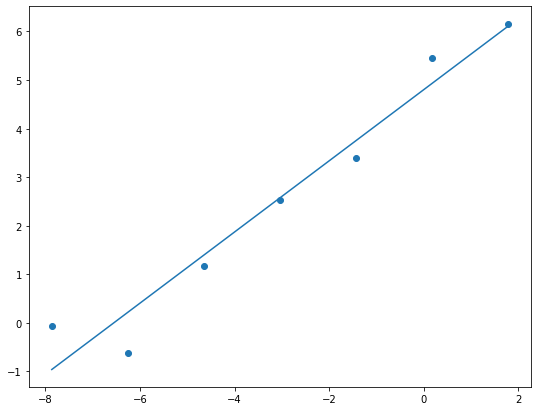

Współczynnik kierunkowy wynosi:  0.873913976195254


In [34]:
x_1 = T/bledy_eul_mayorama[1:,1]
y_1 = bledy_milstein[1:,0]
m_1, b_1 = np.polyfit(x_1, y_1, 1)

x_2 = np.log(T/bledy_eul_mayorama[1:,1])
y_2 = np.log(bledy_milstein[1:,0])
m_2, b_2 = np.polyfit(x_2, y_2, 1)

plt.scatter(x_2, y_2)
plt.plot(x_2, m_2*x_2+b_2)
plt.show()

print("Współczynnik kierunkowy wynosi: ", np.log(m_1)/5)